# [Open in Google Colab](https://colab.research.google.com/github/Jechen00/yolov3-pytorch/blob/main/notebooks/yolov3_training.ipynb)

## Note: The logs are from training on an A100 GPU

# Imports

In [1]:
import torch
from torch import optim
from torch.optim import lr_scheduler

from IPython.display import clear_output, display
import random
import sys, os
import matplotlib.pyplot as plt
import numpy as np

# Importing torchmetrics
try:
    import torchmetrics
except:
    print('\033[1m[ALERT]\033[0m torchmetrics not found. Installing with pip...')
    !pip install torchmetrics

# Check if running in Google Colab
try:
    import google.colab
    print('\033[1m[ALERT]\033[0m Running in Google Colab.')
    IN_COLAB = True
    REPO_PATH = './yolov3-pytorch'

except ImportError:
    print('\033[1m[ALERT]\033[0m Running in yolov3-pytorch repository.')
    IN_COLAB = False
    REPO_PATH = '..'

# Clone repo if it doesn't exist
if IN_COLAB and (not os.path.exists(REPO_PATH)):
    print('\033[1m[ALERT]\033[0m Repository not found. Cloning yolov3-pytorch from GitHub...')
    !git clone https://github.com/Jechen00/yolov3-pytorch.git

# Import repo modules
sys.path.append(os.path.abspath(REPO_PATH))
from src.models import builder, ema_model
from src import engine, schedulers, loss, evaluate, postprocess
from src.data_setup import dataloader_utils, transforms
from src.utils import misc, constants, plot

clear_output(wait = True) # Clear the cluttered output after setup
print(f'\033[1mDevice:\033[0m {constants.DEVICE}')
print(f'\033[1mCPU count:\033[0m {os.cpu_count()}')

misc.set_seed(0) # Set seed for reproducibility

Device: cuda
CPU count: 12


# Model and Dataloader


In [2]:
# Model Configs
BACKBONE_CFGS = os.path.join(REPO_PATH, 'model_configs/darknet53_backbone.cfg')
# BACKBONE_WEIGHTS = os.path.join(REPO_PATH, 'pretrained_weights/darknet53_448.weights') # Pretrained on ImageNet
BACKBONE_WEIGHTS = os.path.join(REPO_PATH, 'pretrained_weights/yolov3_416_coco.weights') # Pretrained on COCO
DETECTOR_CFGS = os.path.join(REPO_PATH, 'model_configs/yolov3_detector_voc.cfg')
INPUT_SHAPE = (1, 3, 416, 416)

# EMA Configs
DECAY = 0.999

# Dataset Configs
ROOT = os.path.join(REPO_PATH, 'data/voc')
DATASET_NAME = 'voc'
DEFAULT_INPUT_SIZE = (416, 416)

ACCUM_BATCH_SIZE = 64 # Used in YOLOv3 paper
BATCH_SIZE = 32 # If lower batch_size needed to prevent OOM
NUM_WORKERS = 10
IGNORE_THRESHOLD = 0.5

MULTI_AUGS = ['mixup', 'mosaic']
MULTI_AUG_PROB = 0.85
MIXUP_ALPHA = 2.0
MULTISCALE_INTERVAL = 10 # In terms of batches
MULTISCALE_SIZES = torch.arange(320, 608 + 32, 32).tolist()


# ---------------------
# Base Model and EMA
# ---------------------
darknet53_backbone = builder.DarkNet53Backbone(cfg_file = BACKBONE_CFGS)
darknet53_backbone.load_weights_file(weights_file = BACKBONE_WEIGHTS, input_shape = INPUT_SHAPE)

yolov3 = builder.YOLOv3(backbone = darknet53_backbone, detector_cfgs = DETECTOR_CFGS)
ema_yolov3 = ema_model.EMA(base_model = yolov3, decay = DECAY, input_shape = INPUT_SHAPE)

if constants.DEVICE.type == 'cuda':
    yolov3.compile(dynamic = True)
    ema_yolov3.compile(dynamic = True)

yolov3 = yolov3.to(constants.DEVICE)
ema_yolov3.to(constants.DEVICE)

scale_anchors, strides, fmap_sizes = yolov3.infer_scale_info(INPUT_SHAPE)


# ---------------------
# Dataloader
# ---------------------
builders = dataloader_utils.get_dataloaders(
    root = ROOT,
    dataset_name = DATASET_NAME,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    default_input_size = DEFAULT_INPUT_SIZE,
    ignore_threshold = IGNORE_THRESHOLD,
    multi_augs = MULTI_AUGS,
    multi_aug_prob = MULTI_AUG_PROB,
    mixup_alpha = MIXUP_ALPHA,
    multiscale_interval = MULTISCALE_INTERVAL,
    multiscale_sizes = MULTISCALE_SIZES,
    scale_anchors = scale_anchors,
    strides = strides,
    device = constants.DEVICE,
    return_builders = True,
    splits = ['train', 'val']
)

train_builder = builders['train']
val_builder = builders['val']

# Loss Function, Optimizer, Scheduler

In [3]:
# Loss Function Configs
LAMBDA_COORD = 1.5
LAMBDA_CLASS = 0.3
LAMBDA_CONF  = 0.5
SCALE_WEIGHTS = [0.8, 1, 1]

USE_FOCAL_CONF = True # Using focal loss for object confidence
ALPHA = 0.25
GAMMA = 1.0

SOFTMAX_PROBS = True # Applies softmax (single-label) to class logits
CLASS_SMOOTHING = 0.05

USE_IOU_COORD = True # Using IoU-based coordinate loss instead of MSE
IOU_COORD_REG = 'ciou'

# Optimizer Configs
MOMENTUM = 0.9
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4

# Scheduler Configs
PRE_WARMUP_LRS = 1e-4
T_MAX = 180
WARMUP_EPOCHS = 5
ETA_MIN = 1e-6


# -----------------------------------------
# Loss Function, Optimizer, Scheduler
# -----------------------------------------
loss_fn = loss.YOLOv3Loss(
    lambda_coord = LAMBDA_COORD,
    lambda_class = LAMBDA_CLASS,
    lambda_conf = LAMBDA_CONF,
    scale_weights = SCALE_WEIGHTS,
    use_focal_conf = USE_FOCAL_CONF,
    alpha = ALPHA,
    gamma = GAMMA,
    softmax_probs = SOFTMAX_PROBS,
    class_smoothing = CLASS_SMOOTHING,
    use_iou_coord = USE_IOU_COORD,
    iou_coord_reg = IOU_COORD_REG,
    scale_anchors = scale_anchors,
    strides = strides
)

optimizer = optim.SGD(
    yolov3.parameters(),
    momentum = MOMENTUM,
    lr = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY
)

scheduler = schedulers.WarmupCosineAnnealingLR(
    optimizer,
    pre_warmup_lrs = PRE_WARMUP_LRS,
    T_max = T_MAX,
    warmup_epochs = WARMUP_EPOCHS,
    eta_min = ETA_MIN
)

# Training-Eval and Checkpoint Configurations

In [4]:
# Training/Evaluation Configs
te_cfgs = engine.TrainEvalConfigs(
    num_epochs = 180,
    accum_steps = (ACCUM_BATCH_SIZE // BATCH_SIZE), # Simulates batch size of 64
    ema_update_interval = 1, # In terms of optimizer steps

    eval_interval = 5, # In terms of epochs
    eval_start_epoch = 5,

    multi_aug_decay_range = None, # Multi-image augmentations don't decay off
    obj_threshold = 0.01,
    nms_threshold = 0.5,
    map_thresholds = [0.5],
    scale_anchors = scale_anchors,
    strides = strides,
)

# Checkpoint Configs
SAVE_DIR = os.path.join(REPO_PATH, 'saved_checkpoints')
CHECKPOINT_NAME = 'yolov3_checkpoint.pth'

ckpt_cfgs = engine.CheckpointConfigs(
    save_dir = SAVE_DIR,
    checkpoint_name = CHECKPOINT_NAME,
    ignore_exists = False,
    resume_path = None,
    resume = False # Training from scratch
)

# Run Training

In [ ]:
base_train_losses, val_losses, eval_history = engine.train(
  base_model = yolov3,
  train_builder = train_builder,
  val_builder = val_builder,
  loss_fn = loss_fn,
  optimizer = optimizer,
  scheduler = scheduler,
  ema = ema_yolov3,
  te_cfgs = te_cfgs,
  ckpt_cfgs = ckpt_cfgs,
  device = constants.DEVICE
)

[NOTE] Checkpoints will be saved to ./saved_checkpoints/yolov3_checkpoint.pth.

================================================= EPOCH   0 =================================================
-------------------------------------------------------------------------------------------------------------
|[BASE | Train Loss ] Coord:       2.0022 | Class:      12.8412 | Conf:       21.5245 | Total:      16.9423 | 
|[BASE | Val Loss   ] Coord:       1.1191 | Class:       7.1046 | Conf:        2.9434 | Total:       5.0112 | 
|[EMA  | Val Loss   ] Coord:       1.7027 | Class:       9.4988 | Conf:        6.2780 | Total:       7.9777 | 
-------------------------------------------------------------------------------------------------------------
|[Time |            ] Train:   221.52 sec | Val:      68.35 sec |                     |                     |

================================================= EPOCH   1 =================================================
------------------------------------

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


================================================= EPOCH   5 =================================================
-------------------------------------------------------------------------------------------------------------
|[BASE | Train Loss ] Coord:       1.2714 | Class:       6.2954 | Conf:        3.4392 | Total:       5.2891 | 
|[BASE | Val Loss   ] Coord:       0.8107 | Class:       2.6377 | Conf:        2.0288 | Total:       2.8861 | 
|[EMA  | Val Loss   ] Coord:       0.8870 | Class:       5.4243 | Conf:        2.7341 | Total:       4.1367 | 
-------------------------------------------------------------------------------------------------------------
|[BASE | Val Metrics] mAP:         0.5788 | mAP (L):     0.7607 | mAP (M):     0.4379 | mAP (S):     0.0707 | 
|[EMA  | Val Metrics] mAP:         0.3792 | mAP (L):     0.5618 | mAP (M):     0.1676 | mAP (S):     0.0256 | 
|[Time |            ] Train:   134.73 sec | Val:     100.41 sec |                     |                     |

====

# Load Checkpoint and Saved Model

In [ ]:
ckpt_path = ckpt_cfgs.save_path
checkpoint = torch.load(ckpt_path, map_location = constants.DEVICE)

darknet53_backbone = builder.DarkNet53Backbone(cfg_file = BACKBONE_CFGS)
yolov3 = builder.YOLOv3(backbone = darknet53_backbone, detector_cfgs = DETECTOR_CFGS)
yolov3 = yolov3.to(constants.DEVICE)

ema_yolov3 = ema_model.EMA(base_model = yolov3, decay = DECAY, input_shape = INPUT_SHAPE)

yolov3.load_state_dict(checkpoint['base_model'])
ema_yolov3.load_state_dict(checkpoint['ema'])

model = ema_yolov3.ema_model # Using EMA model to predict

# Plotting Results

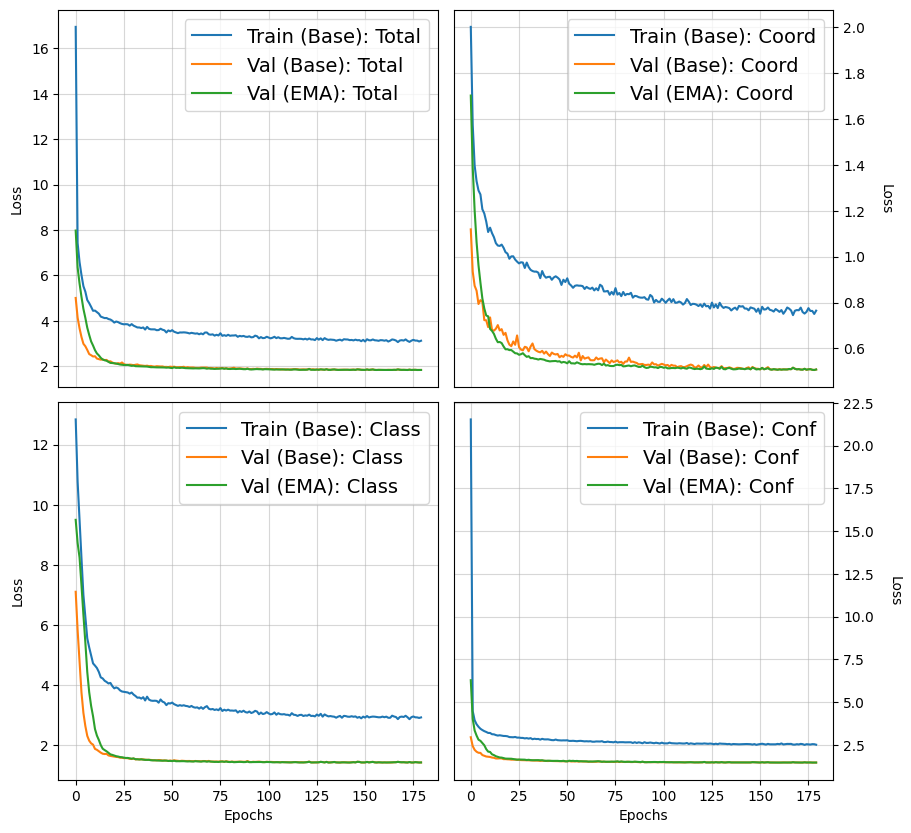

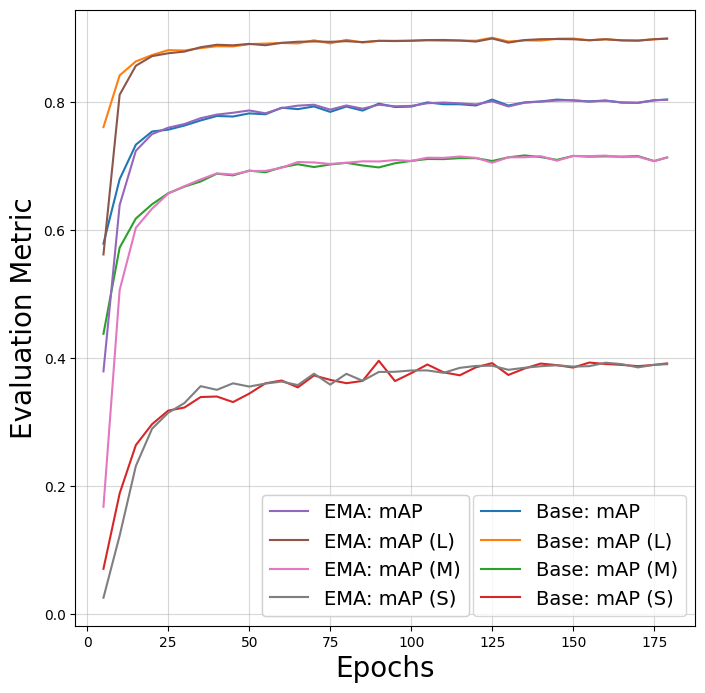

In [ ]:
# Plot losses and eval metrics from training/evaluation
base_train_losses = checkpoint['base_train_losses']
base_val_losses = checkpoint['val_losses'].get('base')
ema_val_losses = checkpoint['val_losses'].get('ema')

base_eval_history = checkpoint['eval_histories'].get('base')
ema_eval_history = checkpoint['eval_histories'].get('ema')

map_keys = ['map', 'map_large', 'map_medium', 'map_small']

loss_fig = plot.plot_loss_results(base_train_losses = base_train_losses,
                                  base_val_losses = base_val_losses,
                                  ema_val_losses = ema_val_losses)
eval_fig = plot.plot_eval_results(base_eval_history = base_eval_history,
                                  ema_eval_history = ema_eval_history,
                                  eval_keys = map_keys)

display(loss_fig)
display(eval_fig)

# Computing mAP

In [ ]:
val_builder.dataset.default_input_size = (416, 416) # Set size of the inputs
val_loader = val_builder.build() # Get dataloader using the builder

evaluate.calc_dataset_map(
    model = model,
    dataloader = val_loader,
    scale_anchors = scale_anchors,
    strides = strides,
    obj_threshold = 0.01,
    nms_threshold = 0.5,
    map_thresholds = [0.5],
    softmax_probs = SOFTMAX_PROBS,
    device = constants.DEVICE,
    class_metrics = True
)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


{'map': tensor(0.8035),
 'map_50': tensor(0.8035),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3912),
 'map_medium': tensor(0.7135),
 'map_large': tensor(0.8990),
 'mar_1': tensor(0.5574),
 'mar_10': tensor(0.8849),
 'mar_100': tensor(0.9338),
 'mar_small': tensor(0.6407),
 'mar_medium': tensor(0.8992),
 'mar_large': tensor(0.9769),
 'map_per_class': tensor([0.8935, 0.8533, 0.8148, 0.6536, 0.6680, 0.8406, 0.8689, 0.8927, 0.6531,
         0.8618, 0.7160, 0.8613, 0.8968, 0.8657, 0.8512, 0.5831, 0.8262, 0.7641,
         0.8982, 0.8077]),
 'mar_100_per_class': tensor([0.9646, 0.9409, 0.9236, 0.8852, 0.8813, 0.9252, 0.9643, 0.9351, 0.9127,
         0.9271, 0.9097, 0.9321, 0.9443, 0.9350, 0.9717, 0.9071, 0.9357, 0.9545,
         0.9768, 0.9501]),
 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19], dtype=torch.int32)}

# Predictions

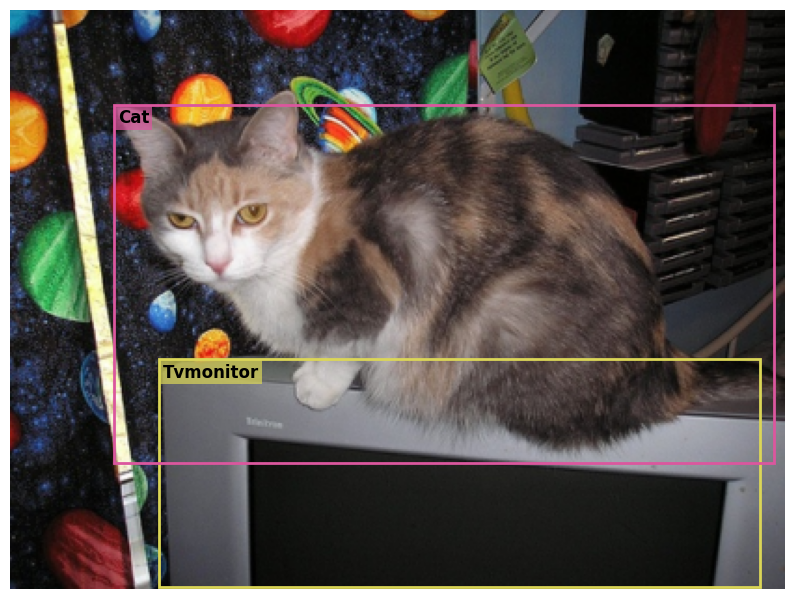

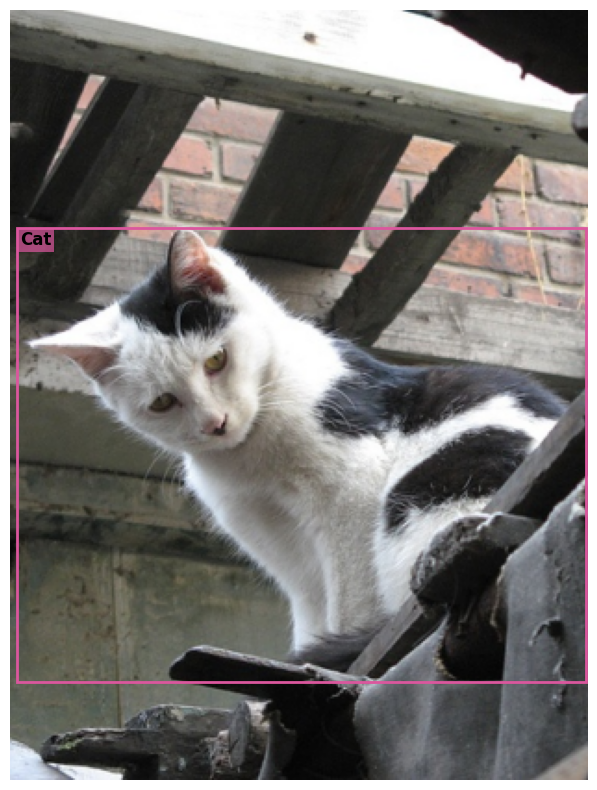

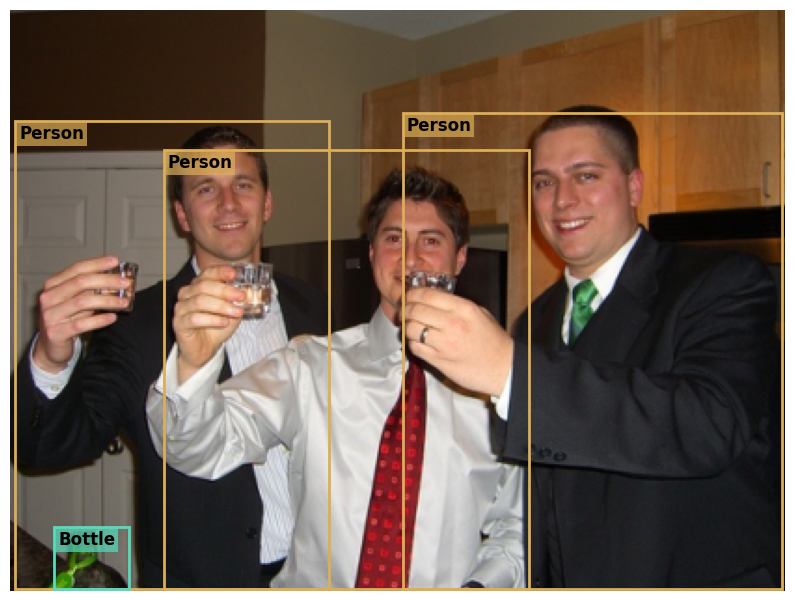

In [ ]:
SIZE = (416, 416) # Set size of the inputs
NUM_SAMPLES = 3

val_dataset = val_builder.dataset
img_transforms = transforms.get_single_transforms(train = False, size = SIZE)
samp_idxs = random.sample(range(len(val_dataset)), NUM_SAMPLES)

for img_idx in samp_idxs:
    fig = plot.draw_preds_yolov3(
        model = model,
        img = val_dataset.get_img(img_idx),
        img_transforms = img_transforms,
        scale_anchors = scale_anchors,
        strides = strides,
        class_names = val_dataset.class_names,
        class_clrs = val_dataset.class_clrs,
        obj_threshold = 0.2,
        nms_threshold = 0.5,
        softmax_probs = SOFTMAX_PROBS,
        rm_lb_pad = True,
        show_probs = False,
        figsize = (10, 10)
    )

    display(fig)

# Download Checkpoint

In [ ]:
if IN_COLAB:
    from google.colab import files
    files.download(ckpt_cfgs.save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>